# Gap-fill meteo variables

</br>

# Settings

## Data settings

In [1]:
SITE_LAT = 47.478333   # CH-LAE
SITE_LON = 8.364389  # CH-LAE
TIMEZONE_OFFSET_TO_UTC_HOURS = 1  # Timezone, e.g. "1" is translated to timezone "UTC+01:00" (CET, winter time)

## Imports

In [33]:
from datetime import datetime
import importlib.metadata
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
sns.set_theme('notebook')
from diive.core.plotting.timeseries import TimeSeries
from diive.core.io.files import load_parquet, save_parquet
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.core.times.times import DetectFrequency
from diive.core.times.times import TimestampSanitizer
from diive.pkgs.createvar.potentialradiation import potrad
from diive.pkgs.gapfilling.xgboost_ts import XGBoostTS
from diive.pkgs.corrections.offsetcorrection import remove_relativehumidity_offset, remove_radiation_zero_offset
import warnings
from influxdb_client.client.warnings import MissingPivotFunction
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.87.0


</br>

# Load data from files

In [3]:
filename_data_simple_2004_2024 = "12.1_METEO_NOT-GAPFILLED_2004-2024.parquet"
data_simple_2004_2024 = load_parquet(filepath=filename_data_simple_2004_2024)
data_simple_2004_2024

Loaded .parquet file 12.1_METEO_NOT-GAPFILLED_2004-2024.parquet (0.045 seconds).
    --> Detected time resolution of <30 * Minutes> / 30min 


,LW_IN_T1_47_1,PA_T1_47_1,PPFD_IN_T1_47_1,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1
TIMESTAMP_MIDDLE,,,,,,
2004-09-20 10:45:00,NaN,NaN,1070.543364,80.503701,NaN,13.300000
2004-09-20 11:15:00,NaN,NaN,881.543364,77.503701,NaN,13.390000
2004-09-20 11:45:00,NaN,NaN,1022.543364,75.803704,NaN,13.810000
2004-09-20 12:15:00,NaN,NaN,1284.543364,71.503701,NaN,14.470000
2004-09-20 12:45:00,NaN,NaN,742.543364,72.703705,NaN,13.980000
...,...,...,...,...,...,...
2024-12-31 21:45:00,232.595527,94.211806,0.000000,87.254008,0.0,-0.504794
2024-12-31 22:15:00,232.609777,94.189013,0.000000,87.430236,0.0,-0.296828
2024-12-31 22:45:00,232.345020,94.169525,0.000000,89.787920,0.0,-0.392922


</br>

# Gap-filling

## SW_IN_T1_47_1

In [4]:
VAR = "SW_IN_T1_47_1"

In [5]:
_df = pd.DataFrame()
_df[VAR] = data_simple_2004_2024[[VAR]].copy()
_df['SW_IN_POT'] = potrad(timestamp_index=_df.index, lat=SITE_LAT, lon=SITE_LON, utc_offset=1)
_df

,SW_IN_T1_47_1,SW_IN_POT
TIMESTAMP_MIDDLE,,
2004-09-20 10:45:00,NaN,833.243912
2004-09-20 11:15:00,NaN,877.607230
2004-09-20 11:45:00,NaN,906.992208
2004-09-20 12:15:00,NaN,920.896059
2004-09-20 12:45:00,NaN,919.080885
...,...,...
2024-12-31 21:45:00,0.0,0.000000
2024-12-31 22:15:00,0.0,0.000000
2024-12-31 22:45:00,0.0,0.000000


In [6]:
xgb = XGBoostTS(
    input_df=_df,
    target_col=VAR,
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=1000,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 355563.


In [7]:
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()


Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2004-09-20 18:45:00 and 2024-12-31 23:45:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:187.20808	validation_1-rmse:187.23916
[1]	validation_0-rmse:156.90019	validation_1-rmse:157.08066
[2]	validation_0-rmse:139.51174	validation_1-rmse:139.72723
[3]	validation_0-rmse:129.93945	validation_1-rmse:130.18473
[4]	validation_0-rmse:124.76174	validation_1-rmse:125.02259
[5]	validation_0-rmse:122.02444	validation_1-rmse:122.32108
[6]	validation_0-rmse:120.37094	validation_1-rmse:120.69973
[7]	validation_0-rmse:119.33020	validation_1-rmse:119.67993
[8]	validation_0-rmse:118.58894	validation_1-rmse:118.95800
[9]	validation_0-rmse:118.02906	validation_1-rmse:118.41308
[10]	validation_0-rmse:117.55467	validation_1-rmse:117.97495
[11]	validation_0-rmse:116.96120	validation_1-rmse:117.40361
[12]	validation_0-rmse:116.62434	validation_1-rmse:117.08419
[13]	validation_0-rmse:1

In [8]:
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()


Gap-filling using final model ...
>>> Using final model on all data to predict target SW_IN_T1_47_1 ...
>>> Using final model on all data to calculate permutation importance ...
>>> Calculating prediction scores based on all data predicting SW_IN_T1_47_1 ...
>>> Predicting target SW_IN_T1_47_1 where all features are available ... predicted 355563 records.
>>> Collecting results for final model ...
>>> Filling 9939 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable SW_IN_T1_47_1_gfXG ...
>>> Restoring original timestamp in results ...

Gap-filling 0 remaining missing records in SW_IN_T1_47_1_gfXG using fallback model ...
>>> Fallback model not necessary, all gaps were already filled.
>>> Combining predictions from full model and fallback model ...

GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (9939 values, SW_IN_T1_47_1_gfXG where flag=1) in comparison to observe

In [9]:
observed = _df[VAR]
gapfilled = xgb.get_gapfilled_target()
data_simple_2004_2024[gapfilled.name] = gapfilled

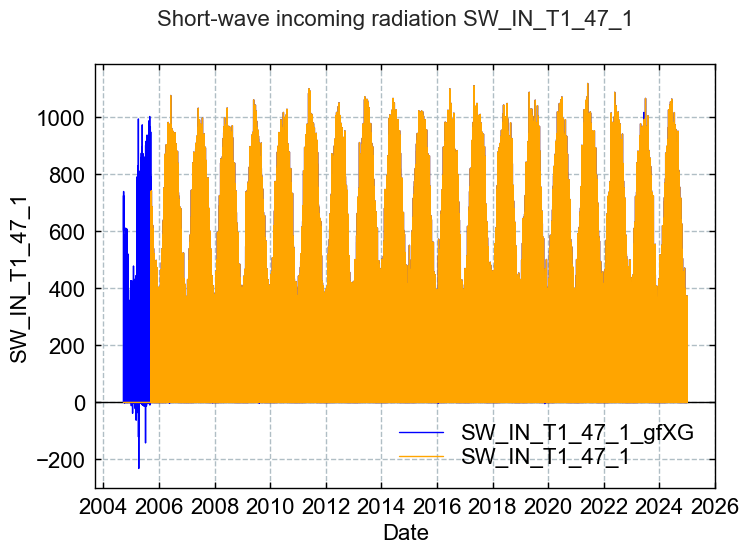

In [10]:
title=f"Short-wave incoming radiation {VAR}"
fig, ax = plt.subplots()
TimeSeries(series=gapfilled, ax=ax).plot(color='blue')
TimeSeries(series=observed, ax=ax).plot(color='orange')
fig.suptitle(f'{title}', fontsize=16)
# ax.set_ylim(-2000, 200)
fig.show()

### Correction: Remove zero offset < 0 from `SW_IN_T1_47_1_gfXG`
- Additional correction needed because gap-filling introduced values < 0

[remove_radiation_zero_offset]  running remove_radiation_zero_offset ...


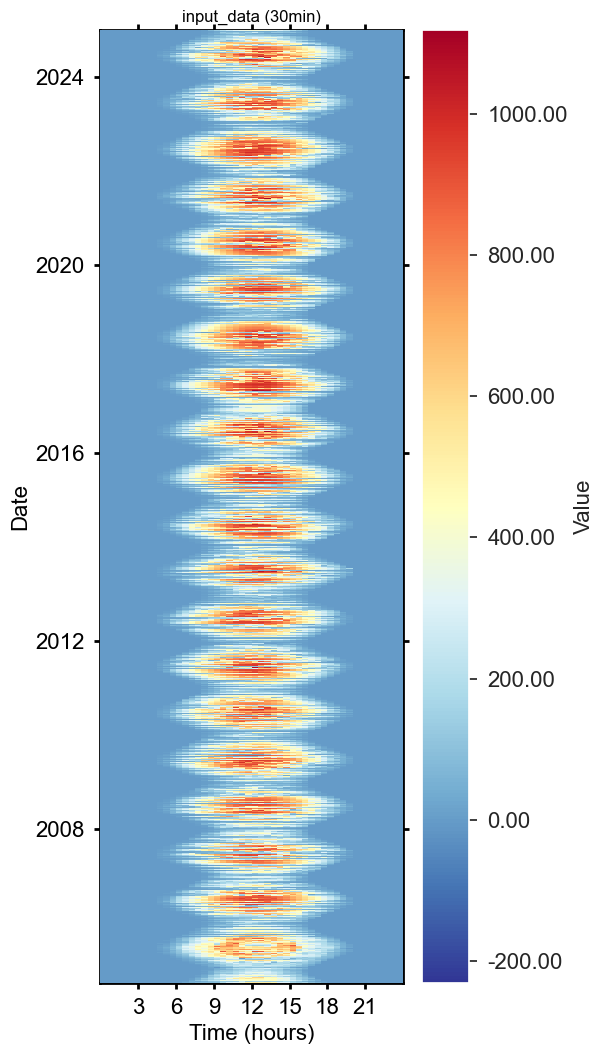

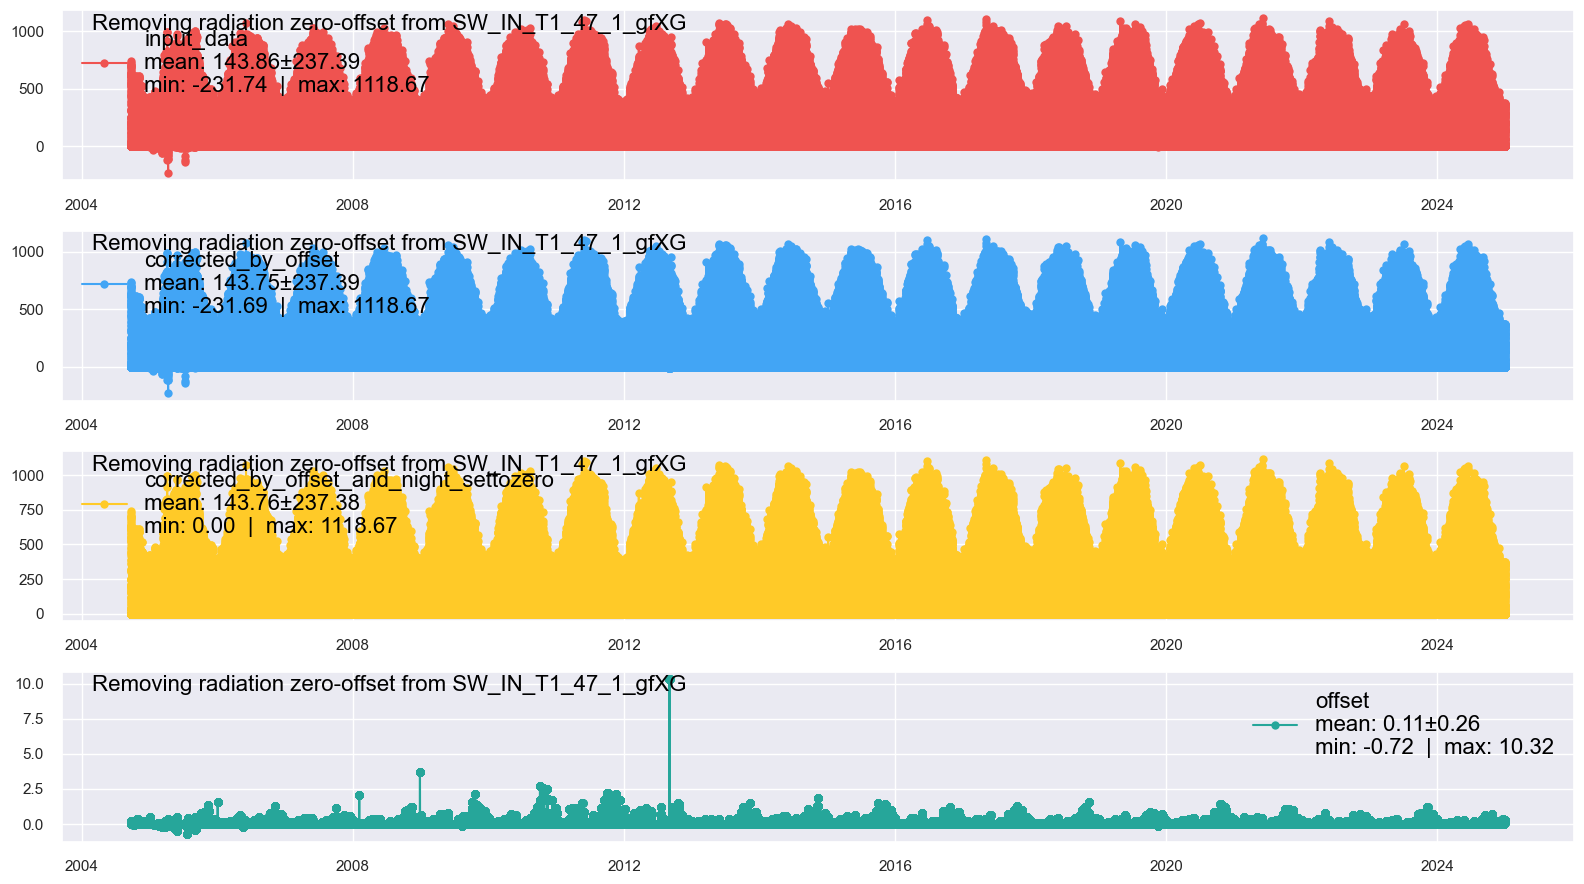

In [35]:
_swin = data_simple_2004_2024['SW_IN_T1_47_1_gfXG'].copy()
_swin_corrected = remove_radiation_zero_offset(series=_swin, lat=SITE_LAT, lon=SITE_LON, utc_offset=1, showplot=True)
data_simple_2004_2024['SW_IN_T1_47_1_gfXG'] = np.nan
data_simple_2004_2024['SW_IN_T1_47_1_gfXG'] = _swin_corrected

## TA_T1_47_1

In [11]:
VAR = "TA_T1_47_1"

In [12]:
_df = pd.DataFrame()
_df['SW_IN_T1_47_1_gfXG'] = data_simple_2004_2024['SW_IN_T1_47_1_gfXG'].copy()
_df[VAR] = data_simple_2004_2024[VAR].copy()
_df['SW_IN_POT'] = potrad(timestamp_index=_df.index, lat=SITE_LAT, lon=SITE_LON, utc_offset=1)
_df

,SW_IN_T1_47_1_gfXG,TA_T1_47_1,SW_IN_POT
TIMESTAMP_MIDDLE,,,
2004-09-20 10:45:00,602.874084,13.300000,833.243912
2004-09-20 11:15:00,703.762207,13.390000,877.607230
2004-09-20 11:45:00,537.947327,13.810000,906.992208
2004-09-20 12:15:00,634.747437,14.470000,920.896059
2004-09-20 12:45:00,634.747437,13.980000,919.080885
...,...,...,...
2024-12-31 21:45:00,0.000000,-0.504794,0.000000
2024-12-31 22:15:00,0.000000,-0.296828,0.000000
2024-12-31 22:45:00,0.000000,-0.392922,0.000000


In [13]:
xgb = XGBoostTS(
    input_df=_df,
    target_col=VAR,
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=1000,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 355563.


In [14]:
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()


Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2004-09-20 11:15:00 and 2024-12-31 23:15:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:6.51444	validation_1-rmse:6.50763
[1]	validation_0-rmse:5.44236	validation_1-rmse:5.43672
[2]	validation_0-rmse:4.78228	validation_1-rmse:4.77956
[3]	validation_0-rmse:4.36988	validation_1-rmse:4.36901
[4]	validation_0-rmse:4.11497	validation_1-rmse:4.11494
[5]	validation_0-rmse:3.96368	validation_1-rmse:3.96609
[6]	validation_0-rmse:3.86908	validation_1-rmse:3.87136
[7]	validation_0-rmse:3.78369	validation_1-rmse:3.78753
[8]	validation_0-rmse:3.73642	validation_1-rmse:3.74109
[9]	validation_0-rmse:3.69167	validation_1-rmse:3.69689
[10]	validation_0-rmse:3.63912	validation_1-rmse:3.64436
[11]	validation_0-rmse:3.60577	validation_1-rmse:3.61172
[12]	validation_0-rmse:3.54697	validation_1-rmse:3.55261
[13]	validation_0-rmse:3.53140	validation_1-rmse:3.53801
[14]	validation_0-r

In [15]:
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()


Gap-filling using final model ...
>>> Using final model on all data to predict target TA_T1_47_1 ...
>>> Using final model on all data to calculate permutation importance ...
>>> Calculating prediction scores based on all data predicting TA_T1_47_1 ...
>>> Predicting target TA_T1_47_1 where all features are available ... predicted 355563 records.
>>> Collecting results for final model ...
>>> Filling 2803 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable TA_T1_47_1_gfXG ...
>>> Restoring original timestamp in results ...

Gap-filling 0 remaining missing records in TA_T1_47_1_gfXG using fallback model ...
>>> Fallback model not necessary, all gaps were already filled.
>>> Combining predictions from full model and fallback model ...

GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (2803 values, TA_T1_47_1_gfXG where flag=1) in comparison to observed targets (352760 

In [16]:
observed = _df[VAR]
gapfilled = xgb.get_gapfilled_target()
data_simple_2004_2024[gapfilled.name] = gapfilled

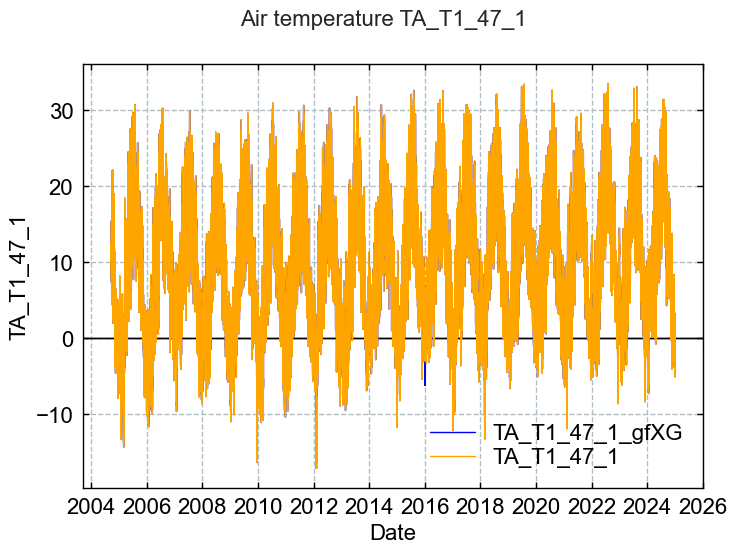

In [17]:
title=f"Air temperature {VAR}"
fig, ax = plt.subplots()
TimeSeries(series=gapfilled, ax=ax).plot(color='blue')
TimeSeries(series=observed, ax=ax).plot(color='orange')
fig.suptitle(f'{title}', fontsize=16)
# ax.set_ylim(-2000, 200)
fig.show()

## PPFD_IN_T1_47_1

In [18]:
VAR = "PPFD_IN_T1_47_1"

In [19]:
_df = pd.DataFrame()
_df[VAR] = data_simple_2004_2024[[VAR]].copy()
_df['SW_IN_T1_47_1_gfXG'] = data_simple_2004_2024[['SW_IN_T1_47_1_gfXG']].copy()
_df['SW_IN_POT'] = potrad(timestamp_index=_df.index, lat=SITE_LAT, lon=SITE_LON, utc_offset=1)
_df

,PPFD_IN_T1_47_1,SW_IN_T1_47_1_gfXG,SW_IN_POT
TIMESTAMP_MIDDLE,,,
2004-09-20 10:45:00,1070.543364,602.874084,833.243912
2004-09-20 11:15:00,881.543364,703.762207,877.607230
2004-09-20 11:45:00,1022.543364,537.947327,906.992208
2004-09-20 12:15:00,1284.543364,634.747437,920.896059
2004-09-20 12:45:00,742.543364,634.747437,919.080885
...,...,...,...
2024-12-31 21:45:00,0.000000,0.000000,0.000000
2024-12-31 22:15:00,0.000000,0.000000,0.000000
2024-12-31 22:45:00,0.000000,0.000000,0.000000


In [20]:
xgb = XGBoostTS(
    input_df=_df,
    target_col=VAR,
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=1000,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 355563.


In [21]:
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()


Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2004-09-20 11:15:00 and 2024-12-31 23:45:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:345.02158	validation_1-rmse:343.95797
[1]	validation_0-rmse:246.75939	validation_1-rmse:246.21279
[2]	validation_0-rmse:179.65743	validation_1-rmse:179.63807
[3]	validation_0-rmse:134.53472	validation_1-rmse:135.10473
[4]	validation_0-rmse:105.39455	validation_1-rmse:106.55698
[5]	validation_0-rmse:86.95574	validation_1-rmse:88.50820
[6]	validation_0-rmse:75.91868	validation_1-rmse:77.88952
[7]	validation_0-rmse:69.08480	validation_1-rmse:71.33225
[8]	validation_0-rmse:64.98887	validation_1-rmse:67.40014
[9]	validation_0-rmse:62.52406	validation_1-rmse:65.07854
[10]	validation_0-rmse:60.97385	validation_1-rmse:63.76672
[11]	validation_0-rmse:59.85523	validation_1-rmse:62.68933
[12]	validation_0-rmse:58.68649	validation_1-rmse:61.58377
[13]	validation_0-rmse:57.53766	validati

In [22]:
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()


Gap-filling using final model ...
>>> Using final model on all data to predict target PPFD_IN_T1_47_1 ...
>>> Using final model on all data to calculate permutation importance ...
>>> Calculating prediction scores based on all data predicting PPFD_IN_T1_47_1 ...
>>> Predicting target PPFD_IN_T1_47_1 where all features are available ... predicted 355563 records.
>>> Collecting results for final model ...
>>> Filling 1282 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable PPFD_IN_T1_47_1_gfXG ...
>>> Restoring original timestamp in results ...

Gap-filling 0 remaining missing records in PPFD_IN_T1_47_1_gfXG using fallback model ...
>>> Fallback model not necessary, all gaps were already filled.
>>> Combining predictions from full model and fallback model ...

GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (1282 values, PPFD_IN_T1_47_1_gfXG where flag=1) in compariso

In [23]:
observed = _df[VAR]
gapfilled = xgb.get_gapfilled_target()
data_simple_2004_2024[gapfilled.name] = gapfilled

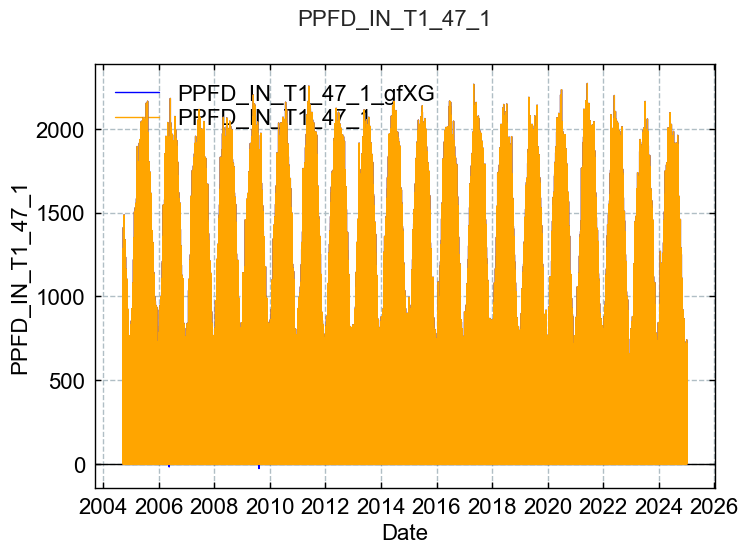

In [24]:
title=f"{VAR}"
fig, ax = plt.subplots()
TimeSeries(series=gapfilled, ax=ax).plot(color='blue')
TimeSeries(series=observed, ax=ax).plot(color='orange')
fig.suptitle(f'{title}', fontsize=16)
# ax.set_ylim(-2000, 200)
fig.show()

</br>

# **Plots**

In [25]:
_plot_df = data_simple_2004_2024.copy()
_plot_df = _plot_df.replace(-9999, np.nan)

## Time series plot

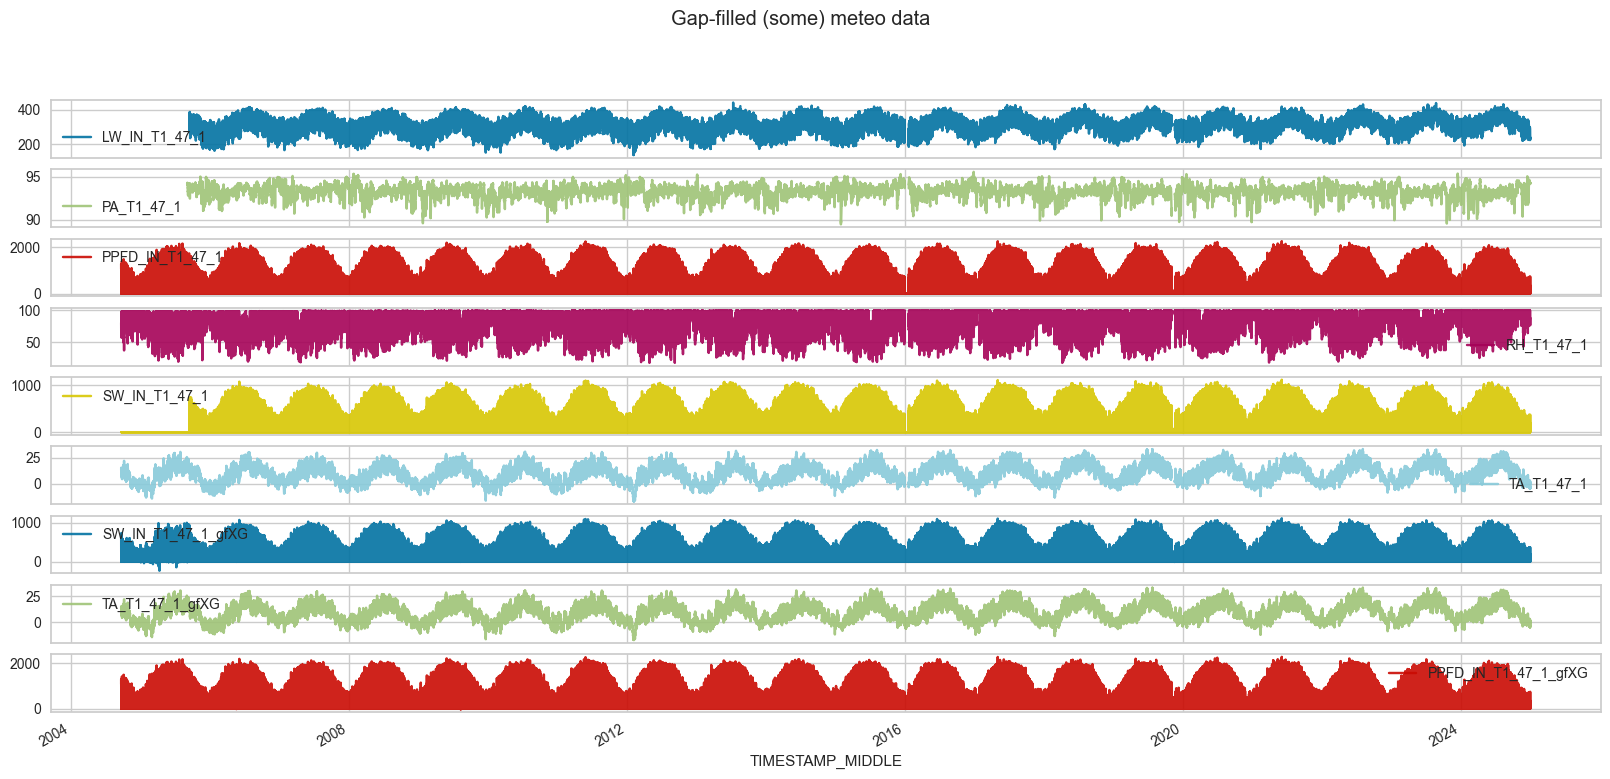

In [26]:
_plot_df.plot(subplots=True, figsize=(20, 9), title="Gap-filled (some) meteo data", alpha=.9, x_compat=True);

## Heatmaps

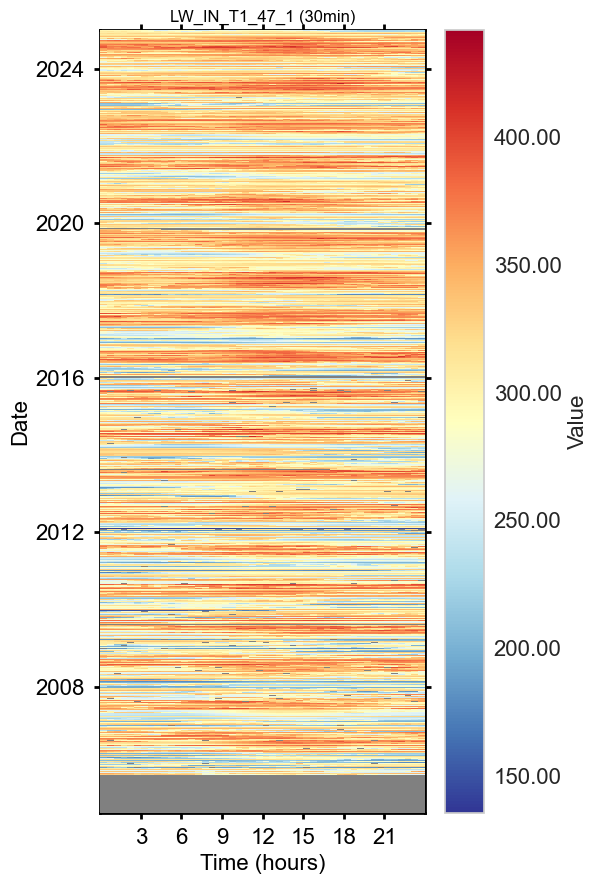

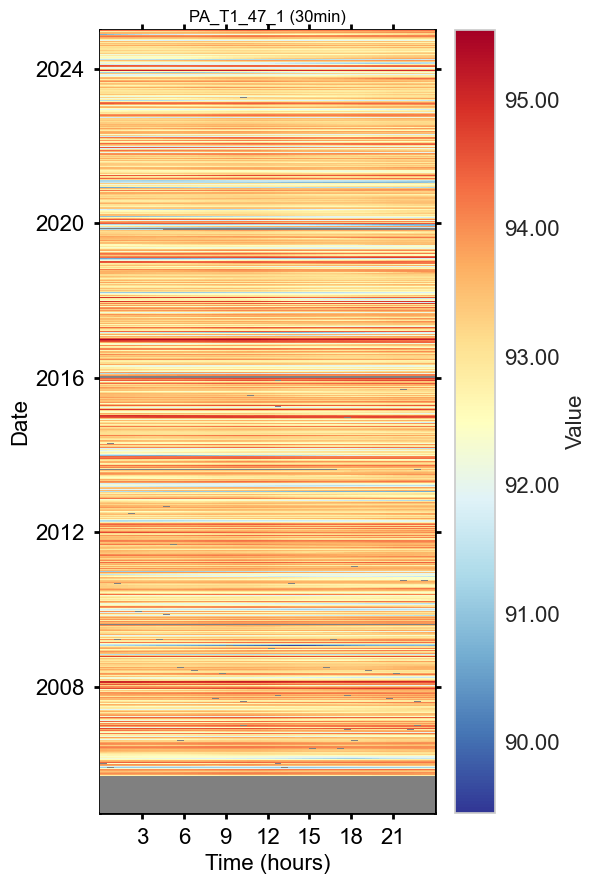

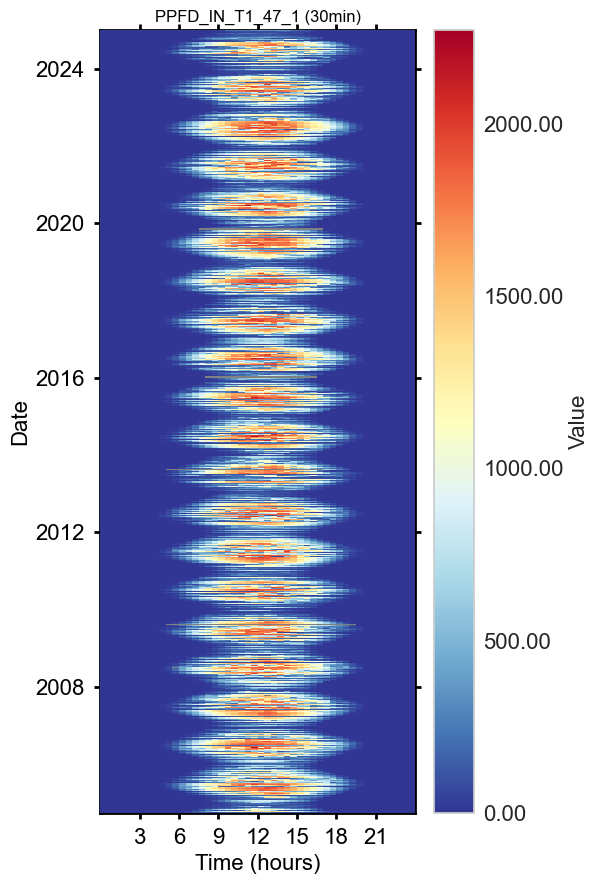

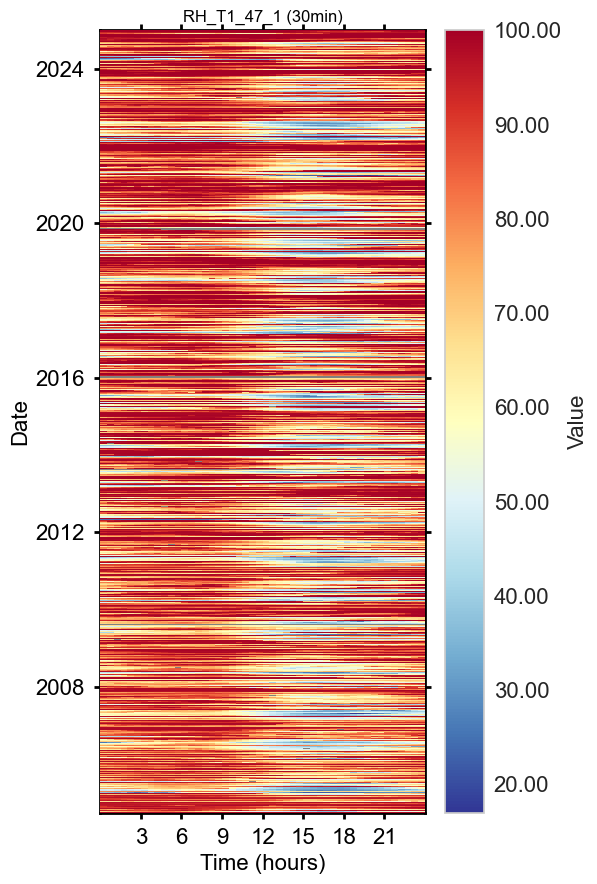

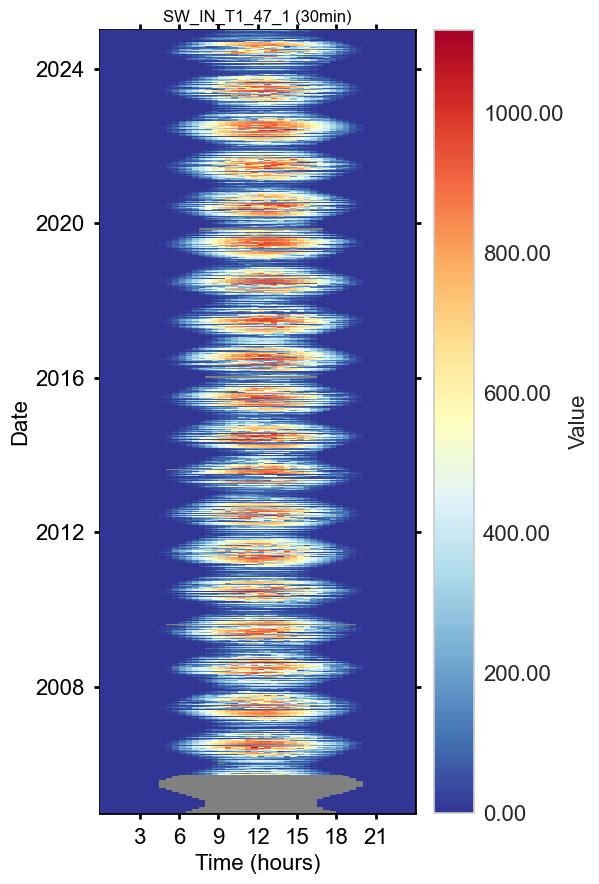

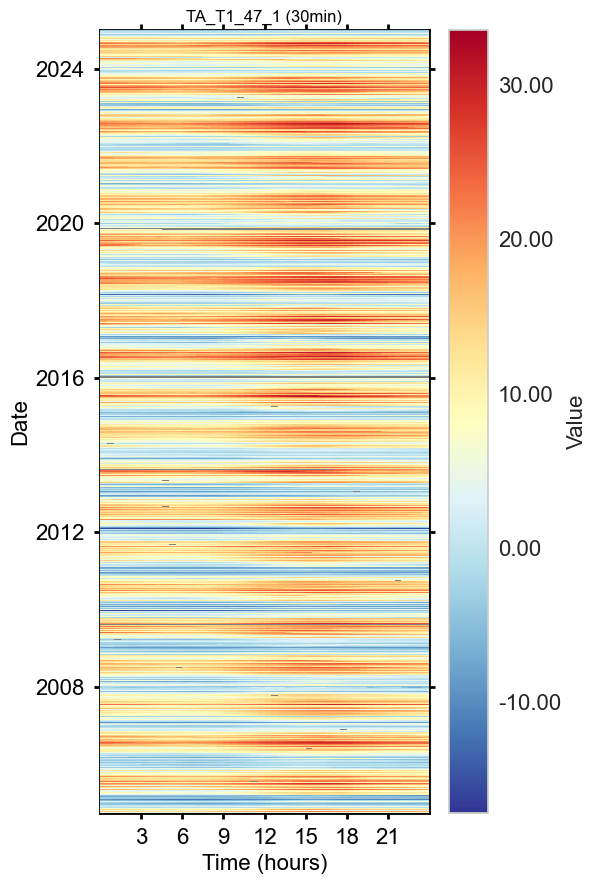

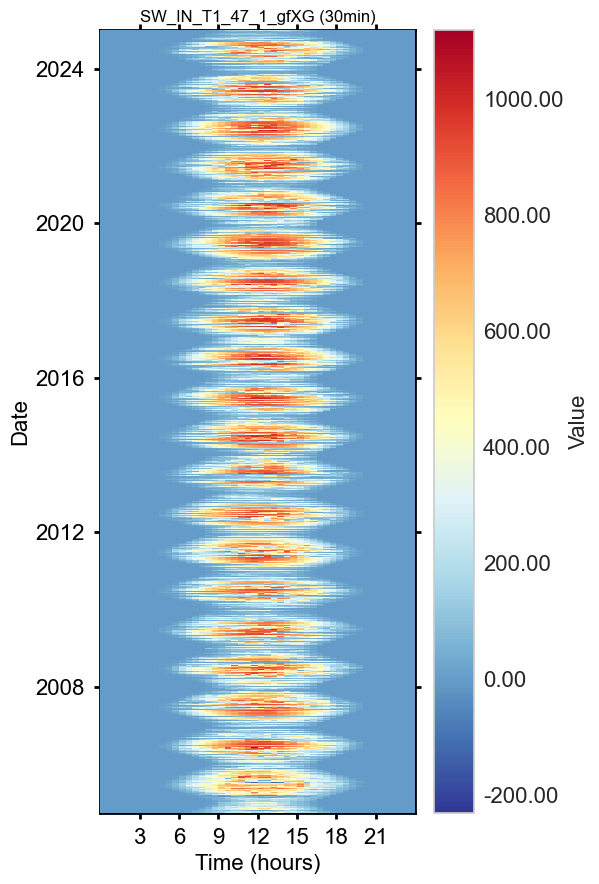

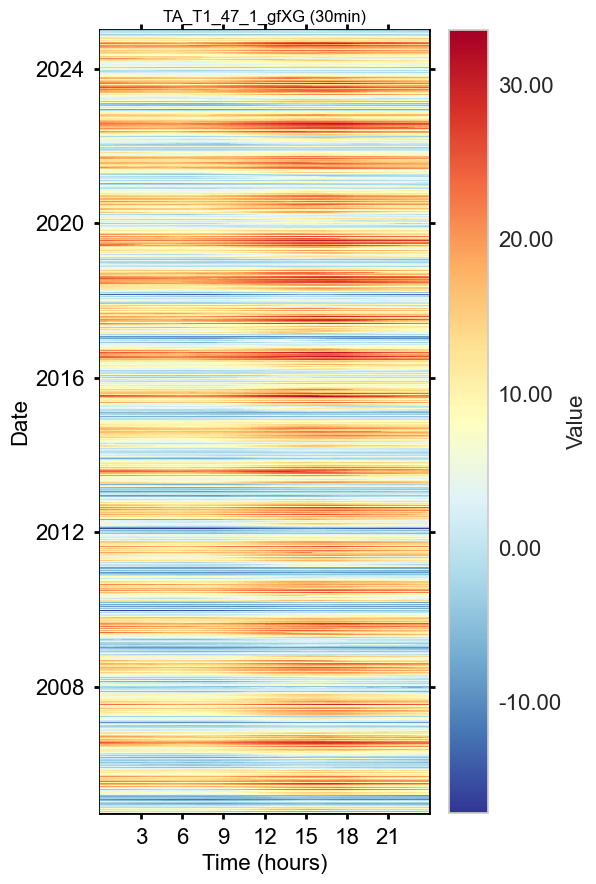

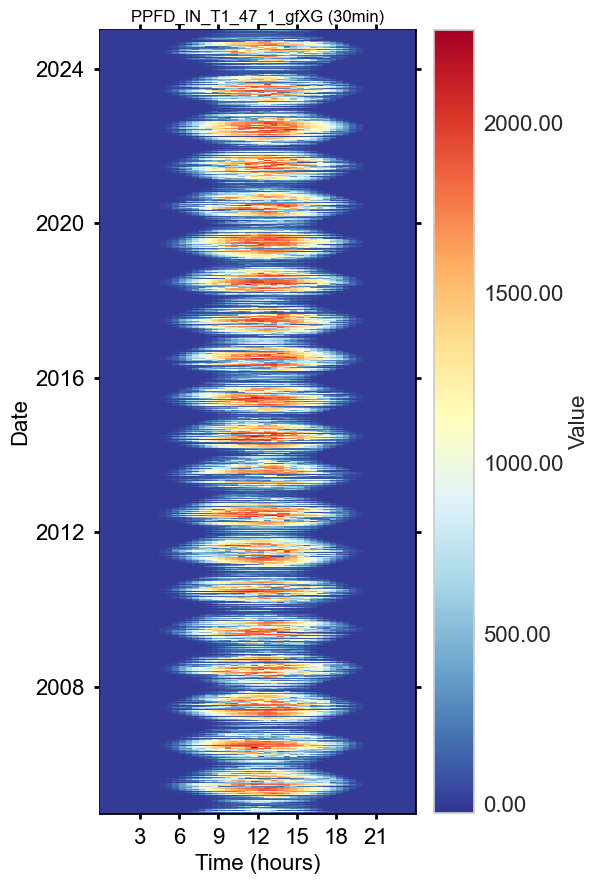

In [27]:
for col in _plot_df.columns:    
    series = _plot_df[col]
    series.name = col
    HeatmapDateTime(series, figsize=(6,9)).show()    

</br>

# Stats

In [28]:
data_simple_2004_2024.describe()

,LW_IN_T1_47_1,PA_T1_47_1,PPFD_IN_T1_47_1,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1,SW_IN_T1_47_1_gfXG,TA_T1_47_1_gfXG,PPFD_IN_T1_47_1_gfXG
count,334651.000000,335887.000000,354281.000000,352774.000000,345624.000000,352760.000000,355563.000000,355563.000000,355563.000000
mean,310.191939,93.234546,288.553030,79.283494,140.243968,8.898763,143.857556,8.885936,289.410291
std,45.718410,0.743782,486.866078,18.817820,237.022077,8.170412,237.390316,8.176580,487.053534
min,135.445129,89.446007,0.000000,16.934985,0.000000,-17.200001,-231.742233,-17.200001,-26.199245
25%,282.017899,92.851006,0.000000,65.473702,0.000000,2.581000,0.000000,2.549883,0.000000
50%,315.560983,93.309998,0.000000,82.847867,0.000000,8.822186,0.000000,8.790000,0.000000
75%,343.077050,93.703298,369.686569,98.043015,182.744032,14.940000,196.350212,14.945253,372.019762
max,441.779694,95.543335,2270.612673,100.000000,1118.665920,33.558765,1118.665920,33.558765,2270.612673


</br>

# Save to file

In [29]:
OUTNAME = "12.3_METEO_GAPFILLED_2004-2024"
OUTPATH = r""
filepath = save_parquet(filename=OUTNAME, data=data_simple_2004_2024, outpath=OUTPATH)
data_simple_2004_2024.to_csv(Path(OUTPATH) / f"{OUTNAME}.csv")

Saved file 12.3_METEO_GAPFILLED_2004-2024.parquet (0.173 seconds).


</br>

# End of notebook.

In [30]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2025-06-11 16:18:53


</br>